<a href="https://colab.research.google.com/github/Song-z-h/data-intensive-proj/blob/master/recomendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto: Recommendation

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Project objective

## Import data

In [ ]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import zipfile

#substitute this path with the path in your drive, or just load the zip file
with zipfile.ZipFile('drive/MyDrive/dataintensive/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('data')


In [ ]:
import pandas as pd

df = pd.read_csv('data/Preprocessed_data.csv')#, names=["user","rating","isbn"])

#dfuser = pd.read_csv('data/reviews/BX-Users.csv', encoding="latin-1", sep=";" , on_bad_lines='skip')

#dfrate = pd.read_csv('data/reviews/BX-Book-Ratings.csv', encoding="latin-1", sep=";" , on_bad_lines='skip')

#dfbook = pd.read_csv('data/reviews/BX-Books.csv', encoding="latin-1", sep=";" , on_bad_lines='skip')



# Data Description

In [ ]:
df.head(5)

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada
3,3,11676,"n/a, n/a, n/a",34.7439,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],NaN,NaN,NaN
4,4,41385,"sudbury, ontario, canada",34.7439,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],sudbury,ontario,canada


In [ ]:
ratings_df =df[["user_id","isbn","rating"]]
ratings_df.head(5)

,user_id,isbn,rating
0,2,0195153448,0
1,8,0002005018,5
2,11400,0002005018,0
3,11676,0002005018,8
4,41385,0002005018,0


In [ ]:
ratings = ratings_df.head(200000)

In [ ]:
ratings.set_index(["user_id", "isbn"], inplace=True)

In [ ]:
ratings.head(3)

,,rating
user_id,isbn,
2,0195153448,0
8,0002005018,5
11400,0002005018,0


In [ ]:
ratings = ratings["rating"].unstack("isbn")

In [ ]:
ratings.iloc[:5, :5]

isbn,0002005018,0002740230,0006276199,0006329527,000636988X
user_id,,,,,
2,NaN,NaN,NaN,NaN,NaN
8,5.0,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN


In [ ]:
R = ratings.fillna(0).values

In [ ]:
R[:5, :5]

array([[0., 0., 0., 0., 0.],
       [5., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [ ]:
P = ratings.notna().values

In [ ]:
P[:5, :5]

array([[False, False, False, False, False],
       [ True, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

# Data exploration

Extracting useful information from the matrix `P` and `R`.

In [ ]:
print("number of ratings:", P.sum())
print("number of users who has rated a book", P.shape[0])
print("number of books: ", P.shape[1])
print("average ratings from users: ", R.mean(where=P))
print("the maximum numbers of ratings given by an user: ",P.sum(1).max())
print("the book with minimum number of ratings: ", P.sum(0).min())

number of ratings: 200000
number of users who has rated a book 40447
number of books:  6911
average ratings from users:  3.165975
the maximum numbers of ratings given by an user:  1516
the book with minimum number of ratings:  1


In [ ]:
isbn = ratings.columns[P.sum(0).argmax()]
book_name = df[df['isbn'] == isbn]['book_title']
print("the book name with maximum number of ratings:")
book_name.head(1)

the book name with maximum number of ratings:


769    Wild Animus
Name: book_title, dtype: object

In [ ]:
print("5 books with the most average rating:")
indexes = (-R.mean(0, where=P)).argsort()[:5]
book_isbns = ratings.columns[indexes]
book_with_most_rating_names = [df[df['isbn'] == name]['book_title'] for name in book_isbns]
book_with_most_rating_names

5 books with the most average rating:


[106828    Nina: Adolescence
 Name: book_title, dtype: object,
 131139    Babbitt
 Name: book_title, dtype: object,
 76345    The Burberry Style
 Name: book_title, dtype: object,
 180453    Themen Neu 1 Arbeitsbuch
 Name: book_title, dtype: object,
 76344    Heavier Than Air (Balona Books)
 Name: book_title, dtype: object]

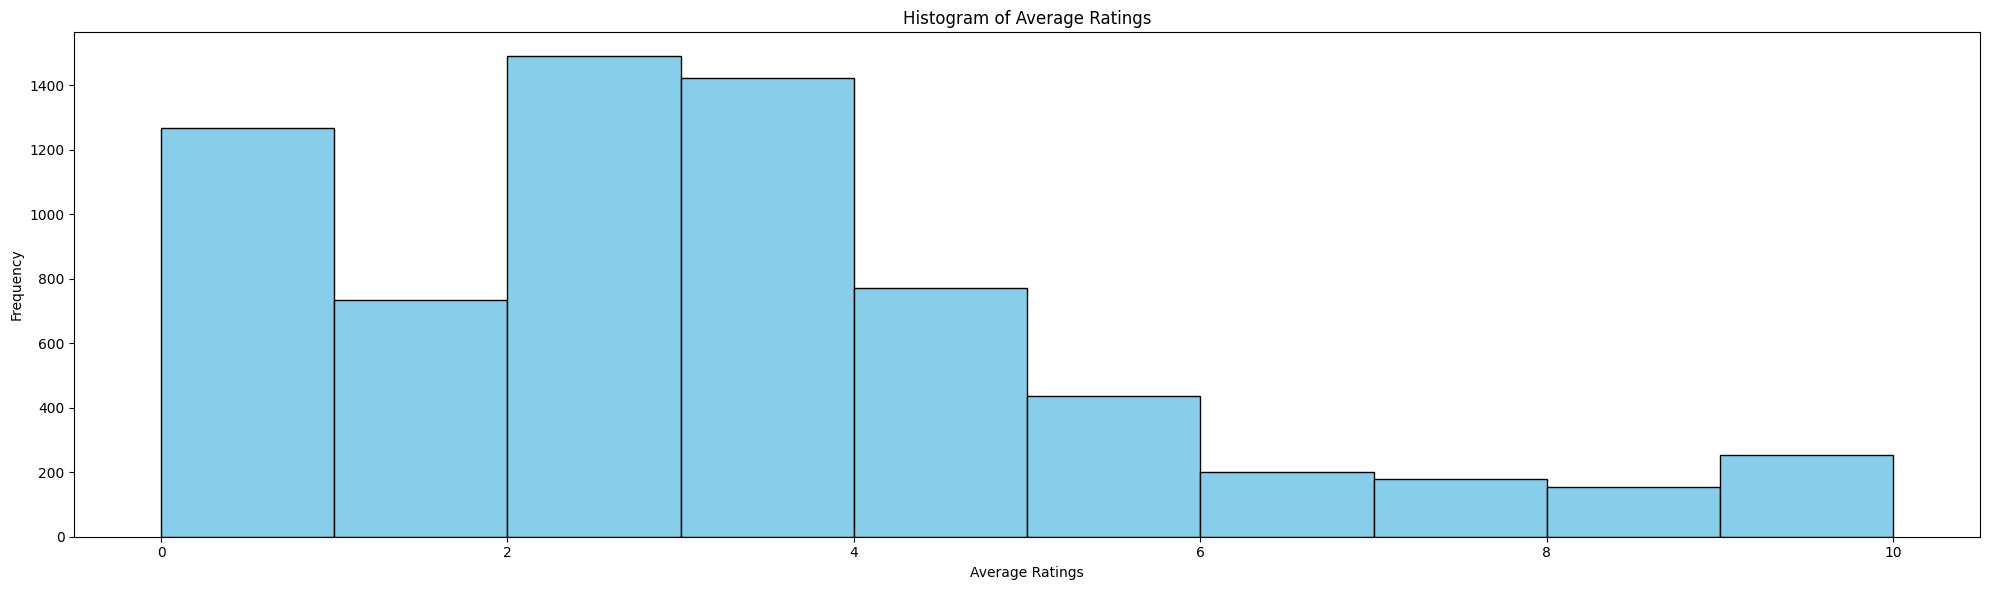

In [ ]:
most_rated_books_average_ratings = -np.sort((-R.mean(0, where=P)))
plt.figure(figsize=(20, 6))
plt.hist(most_rated_books_average_ratings, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Average Ratings')
plt.ylabel('Frequency') # the number of book that share the same average rating score
plt.title('Histogram of Average Ratings')
plt.tight_layout()
plt.show()

# Data preparation